**Stock Market Prediction Using Numerical And Textual Analysis**

Dataset Used:

Historical Stock Prices:https://in.finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch

Textual News Headlines:https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH

Downloading Dependencies

In [1]:
!pip install nltk
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing,metrics
from sklearn.preprocessing import MinMaxScaler 

Importing Dataset

In [3]:
stock_price=pd.read_csv('AAPL1.csv')
stock_headlines=pd.read_csv("india-news-headlines.csv",quoting=csv.QUOTE_NONE)

In [4]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.254756,373699200
1,2001-01-09,0.300223,0.315011,0.295759,0.306920,0.264370,588929600
2,2001-01-10,0.297991,0.303571,0.286830,0.295759,0.254756,580781600
3,2001-01-11,0.290179,0.330357,0.290179,0.321429,0.276867,803734400
4,2001-01-12,0.319196,0.321429,0.304688,0.306920,0.264370,423376800


In [5]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,"""win over cena satisfying but defeating undert..."
1,20010102,unknown,"""Status quo will not be disturbed at Ayodhya; ..."
2,20010102,unknown,"""Fissures in Hurriyat over Pak visit"""
3,20010102,unknown,"""America's unwanted heading for India?"""
4,20010102,unknown,"""For bigwigs; it is destination Goa"""


Feature Engineering

In [6]:
len(stock_headlines),len(stock_price)

(207265, 4272)

In [7]:
#checking The presence of Null values in both the datasets
stock_price.isna().any(),stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

Feature Engineering For Stock Prices

In [8]:
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200
2001-01-09,0.306920,0.300223,0.315011,0.295759,588929600
2001-01-10,0.295759,0.297991,0.303571,0.286830,580781600
2001-01-11,0.321429,0.290179,0.330357,0.290179,803734400
2001-01-12,0.306920,0.319196,0.321429,0.304688,423376800
...,...,...,...,...,...
2017-12-22,43.752499,43.669998,43.855000,43.625000,65397600
2017-12-26,42.642502,42.700001,42.867500,42.419998,132742000
2017-12-27,42.650002,42.525002,42.695000,42.427502,85992800


Feature Engineering for Stock headlines

In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,"""win over cena satisfying but defeating undert..."
2001-01-02,"""Status quo will not be disturbed at Ayodhya; ..."
2001-01-03,"""Powerless north India gropes in the dark"",""Th..."
2001-01-04,"""The string that pulled Stephen Hawking to Ind..."
2001-01-05,"""Light combat craft takes India into club clas..."
...,...
2003-05-10,"""Citizen's initiative sought to improve city's..."
2003-05-11,"""Cricket will always be my first love: Jadeja""..."
2003-05-12,"""SACRED SPACEBRThe Past"",""THE SPEAKING TREEBRI..."


Combining Both The The Datasets

In [10]:
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"""Sangh Parivar; Babri panel up the ante"",""Fron..."
2001-01-09,0.306920,0.300223,0.315011,0.295759,588929600.0,"""Financier Bharat Shah held for alleged links ..."
2001-01-10,0.295759,0.297991,0.303571,0.286830,580781600.0,"""Fend for yourselves; Pande tells doctors"",""Bu..."
2001-01-11,0.321429,0.290179,0.330357,0.290179,803734400.0,"""shreyas gopal scores ton as karnataka stay on..."
2001-01-23,0.366071,0.344866,0.373884,0.340402,879530400.0,"""Sonia takes on the Hindutva brigade"",""Congres..."
...,...,...,...,...,...,...
2003-05-08,0.321429,0.316071,0.322679,0.308750,687736000.0,"""A-I to be fully operational soon: Naik"",""Goa ..."
2003-05-09,0.326786,0.327321,0.328571,0.319286,588386400.0,"""SACRED SPACEBRTalking Peace"",""THE SPEAKING TR..."
2003-05-12,0.331429,0.324107,0.334643,0.323750,419372800.0,"""SACRED SPACEBRThe Past"",""THE SPEAKING TREEBRI..."
2003-05-13,0.333393,0.329107,0.338750,0.320536,446796000.0,"""Goa unit of Janata Party formed"",""NFL title t..."


Calculating Sentiment Scores

In [11]:
#Setting the sentiment columns
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"""Sangh Parivar; Babri panel up the ante"",""Fron...",,,,
2001-01-09,0.306920,0.300223,0.315011,0.295759,588929600.0,"""Financier Bharat Shah held for alleged links ...",,,,
2001-01-10,0.295759,0.297991,0.303571,0.286830,580781600.0,"""Fend for yourselves; Pande tells doctors"",""Bu...",,,,
2001-01-11,0.321429,0.290179,0.330357,0.290179,803734400.0,"""shreyas gopal scores ton as karnataka stay on...",,,,
2001-01-23,0.366071,0.344866,0.373884,0.340402,879530400.0,"""Sonia takes on the Hindutva brigade"",""Congres...",,,,


In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"""Sangh Parivar; Babri panel up the ante"",""Fron...",-0.9638,0.119,0.855,0.026
2001-01-09,0.306920,0.300223,0.315011,0.295759,588929600.0,"""Financier Bharat Shah held for alleged links ...",-0.9559,0.121,0.822,0.056
2001-01-10,0.295759,0.297991,0.303571,0.286830,580781600.0,"""Fend for yourselves; Pande tells doctors"",""Bu...",-0.5719,0.227,0.773,0.000
2001-01-11,0.321429,0.290179,0.330357,0.290179,803734400.0,"""shreyas gopal scores ton as karnataka stay on...",0.0000,0.092,0.816,0.092
2001-01-23,0.366071,0.344866,0.373884,0.340402,879530400.0,"""Sonia takes on the Hindutva brigade"",""Congres...",0.9295,0.036,0.874,0.090


Finalising Stock Data and Writing to the disk

In [17]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
2001-01-09,0.306920,-0.9559,0.121,0.822,0.056,0.300223,0.315011,0.295759,588929600.0
2001-01-10,0.295759,-0.5719,0.227,0.773,0.000,0.297991,0.303571,0.286830,580781600.0
2001-01-11,0.321429,0.0000,0.092,0.816,0.092,0.290179,0.330357,0.290179,803734400.0
2001-01-23,0.366071,0.9295,0.036,0.874,0.090,0.344866,0.373884,0.340402,879530400.0


In [18]:
#writing the stock_data to the disk
stock_data.to_csv('stock_data.csv')

Rereading the dataset

In [19]:
stock_data=pd.read_csv("stock_data.csv",index_col=False)

#Renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

#Setting the date as index column
stock_data.set_index('Date', inplace=True)

stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
2001-01-09,0.306920,-0.9559,0.121,0.822,0.056,0.300223,0.315011,0.295759,588929600.0
2001-01-10,0.295759,-0.5719,0.227,0.773,0.000,0.297991,0.303571,0.286830,580781600.0
2001-01-11,0.321429,0.0000,0.092,0.816,0.092,0.290179,0.330357,0.290179,803734400.0
2001-01-23,0.366071,0.9295,0.036,0.874,0.090,0.344866,0.373884,0.340402,879530400.0


Feature Engineering of Stock Data

In [21]:
stock_data.shape

(561, 9)

In [22]:
#Checking for any null variable present
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [23]:
#displaying stock_data stratestics
stock_data.describe(include="all")

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,5.610000e+02
mean,0.336613,-0.762800,0.113893,0.804968,0.081080,0.335755,0.344022,0.328191,3.326028e+08
std,0.068215,0.560117,0.036337,0.056634,0.041354,0.067900,0.069907,0.065856,2.032624e+08
min,0.234286,-0.999700,0.000000,0.000000,0.000000,0.231964,0.235536,0.227143,3.934000e+07
25%,0.267143,-0.998100,0.096000,0.783000,0.065000,0.266071,0.270893,0.261607,2.145304e+08
50%,0.333036,-0.995000,0.114000,0.805000,0.078000,0.330714,0.340536,0.323393,2.852248e+08
75%,0.401429,-0.947900,0.132000,0.829000,0.090000,0.399286,0.410714,0.388571,3.905328e+08
max,0.474821,0.995900,0.444000,1.000000,0.608000,0.470357,0.476786,0.460000,1.873670e+09


In [24]:
#Stock_data_information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 2001-01-08 to 2003-05-14
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     561 non-null    float64
 1   compound  561 non-null    float64
 2   negative  561 non-null    float64
 3   neutral   561 non-null    float64
 4   positive  561 non-null    float64
 5   Open      561 non-null    float64
 6   High      561 non-null    float64
 7   Low       561 non-null    float64
 8   Volume    561 non-null    float64
dtypes: float64(9)
memory usage: 63.8+ KB


Exploratory data analysis (EDA) of stock_data

Text(0, 0.5, 'Close Price ($)')

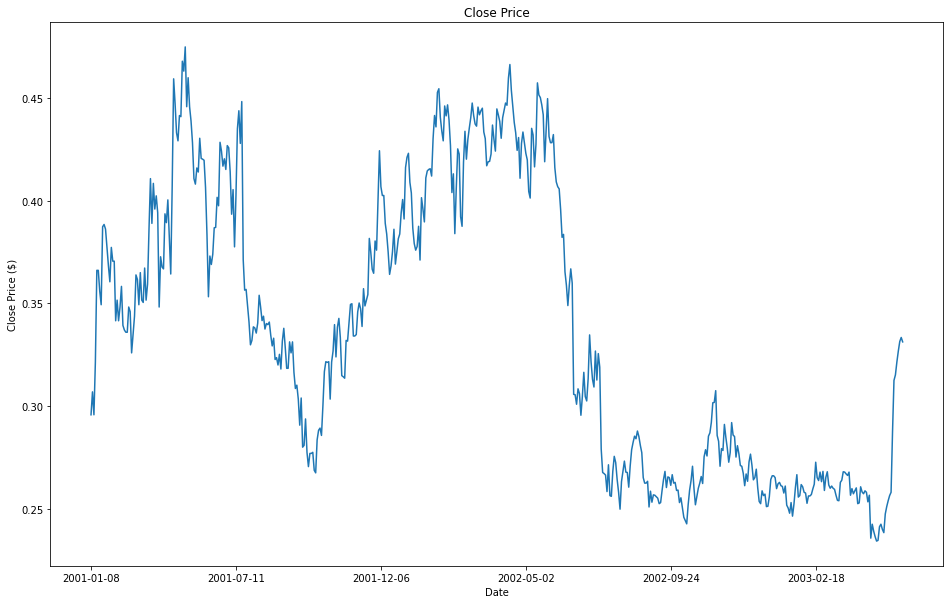

In [25]:

# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [26]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-25,0.329719,-0.493057,0.118286,0.827857,0.053571,0.324458,0.337532,0.314254,633353600.0
2001-01-26,0.337372,-0.227857,0.110714,0.822571,0.066429,0.330995,0.344747,0.322226,648942400.0
2001-01-29,0.348852,0.047229,0.099286,0.823571,0.077000,0.338010,0.355230,0.329879,687028000.0


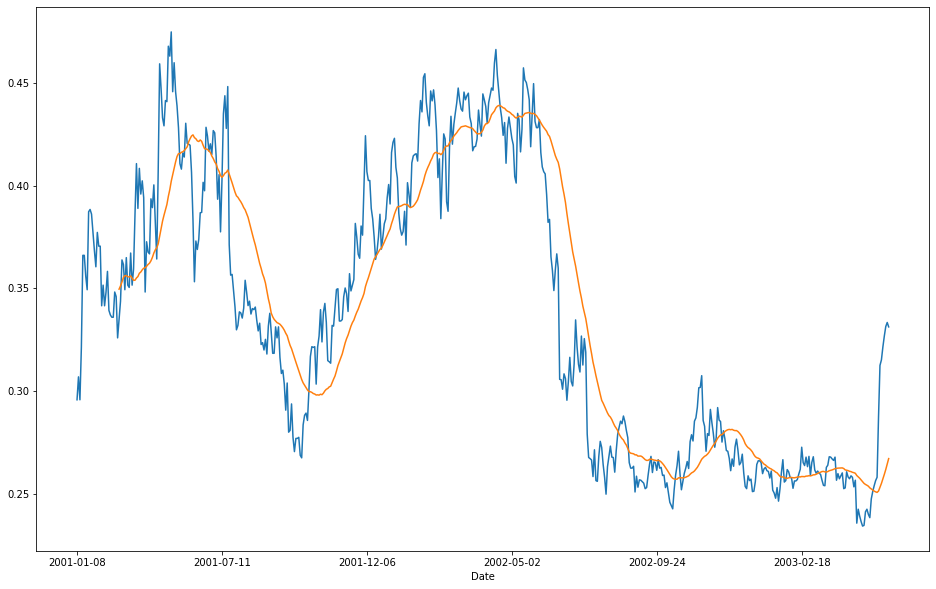

In [27]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [28]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
2001-01-09,0.306920,-0.9559,0.121,0.822,0.056,0.300223,0.315011,0.295759,588929600.0
2001-01-10,0.295759,-0.5719,0.227,0.773,0.000,0.297991,0.303571,0.286830,580781600.0
2001-01-11,0.321429,0.0000,0.092,0.816,0.092,0.290179,0.330357,0.290179,803734400.0
2001-01-23,0.366071,0.9295,0.036,0.874,0.090,0.344866,0.373884,0.340402,879530400.0
...,...,...,...,...,...,...,...,...,...
2003-05-08,0.321429,-0.9967,0.139,0.758,0.103,0.316071,0.322679,0.308750,687736000.0
2003-05-09,0.326786,0.8871,0.111,0.768,0.121,0.327321,0.328571,0.319286,588386400.0
2003-05-12,0.331429,-0.9985,0.133,0.787,0.080,0.324107,0.334643,0.323750,419372800.0


Data Preparation for Modelling

In [29]:
#Calculating data to use
percentage_data=1.0
data_to_use=int(percentage_data*(len(stock_data)-1))

#Using 80% of data for training
train_end=int(0.8*data_to_use)
total_data=len(stock_data)
start=total_data-data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 448
Number of records in Test Data: 113


In [30]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-09    0.306920
2001-01-10    0.295759
2001-01-11    0.321429
2001-01-23    0.366071
2001-01-24    0.366071
                ...   
2003-05-08    0.321429
2003-05-09    0.326786
2003-05-12    0.331429
2003-05-13    0.333393
2003-05-14    0.331250
Name: Close, Length: 560, dtype: float64

In [31]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-09,0.306920,0.295759,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
2001-01-10,0.295759,0.321429,-0.5719,0.0000,580781600.0,0.297991,0.303571,0.286830
2001-01-11,0.321429,0.366071,0.0000,0.9295,803734400.0,0.290179,0.330357,0.290179
2001-01-23,0.366071,0.366071,0.9295,-0.9039,879530400.0,0.344866,0.373884,0.340402
2001-01-24,0.366071,0.356027,-0.9039,-0.9854,717091200.0,0.368304,0.369420,0.349330
2001-01-25,0.356027,0.349330,-0.9854,0.8926,489708800.0,0.367188,0.367188,0.352679
2001-01-26,0.349330,0.387277,0.8926,0.9697,482820800.0,0.348214,0.353795,0.340402
2001-01-29,0.387277,0.388393,0.9697,-0.8580,855528800.0,0.349330,0.388393,0.349330
2001-01-30,0.388393,0.386161,-0.8580,-0.5591,692423200.0,0.385045,0.392857,0.372768


Setting the Target Variable and the Feature Dataset

In [32]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-09    0.295759
2001-01-10    0.321429
2001-01-11    0.366071
2001-01-23    0.366071
2001-01-24    0.356027
                ...   
2003-05-07    0.321429
2003-05-08    0.326786
2003-05-09    0.331429
2003-05-12    0.333393
2003-05-13    0.331250
Name: close_price_shifted, Length: 559, dtype: float64

In [33]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-09,0.306920,-0.9559,-0.5719,5.889296e+08,0.300223,0.315011,0.295759
2001-01-10,0.295759,-0.5719,0.0000,5.807816e+08,0.297991,0.303571,0.286830
2001-01-11,0.321429,0.0000,0.9295,8.037344e+08,0.290179,0.330357,0.290179
2001-01-23,0.366071,0.9295,-0.9039,8.795304e+08,0.344866,0.373884,0.340402
2001-01-24,0.366071,-0.9039,-0.9854,7.170912e+08,0.368304,0.369420,0.349330
...,...,...,...,...,...,...,...
2003-05-07,0.315179,-0.9921,-0.9967,1.054379e+09,0.309464,0.325714,0.305536
2003-05-08,0.321429,-0.9967,0.8871,6.877360e+08,0.316071,0.322679,0.308750
2003-05-09,0.326786,0.8871,-0.9985,5.883864e+08,0.327321,0.328571,0.319286


 Scaling the Target Variable and the Feature Dataset

In [37]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array(y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.39606294, -0.95610343, -0.57125676, ..., -0.42734057,
         -0.3411399 , -0.41065976],
        [-0.48886441, -0.57125676,  0.00190419, ..., -0.44606595,
         -0.43597927, -0.48735061],
        [-0.27542354,  0.00190419,  0.9334536 , ..., -0.51160479,
         -0.21391917, -0.45858617],
        ...,
        [-0.23088116,  0.89096011, -0.99879735, ..., -0.20000168,
         -0.22872539, -0.20858724],
        [-0.19227555, -0.99879735, -0.94097013, ..., -0.22696556,
         -0.17838756, -0.17024612],
        [-0.17594529, -0.94097013,  0.58027661, ..., -0.18501802,
         -0.1443399 , -0.19785104]]), array([[-0.48886441],
        [-0.27542354],
        [ 0.09576569],
        [ 0.09576569],
        [ 0.01225186],
        [-0.04343235],
        [ 0.2720893 ],
        [ 0.28136862],
        [ 0.26280999],
        [ 0.18856715],
        [ 0.11433263],
        [ 0.04936911],
        [ 0.18856715],
        [ 0.13289126],
        [ 0.13289126],
        [-0.10838755],
      

In [38]:
y

array([[-0.48886441],
       [-0.27542354],
       [ 0.09576569],
       [ 0.09576569],
       [ 0.01225186],
       [-0.04343235],
       [ 0.2720893 ],
       [ 0.28136862],
       [ 0.26280999],
       [ 0.18856715],
       [ 0.11433263],
       [ 0.04936911],
       [ 0.18856715],
       [ 0.13289126],
       [ 0.13289126],
       [-0.10838755],
       [-0.0248654 ],
       [-0.10838755],
       [-0.05271166],
       [ 0.03081048],
       [-0.12694618],
       [-0.14550481],
       [-0.15478413],
       [-0.15478413],
       [-0.05271166],
       [-0.07127029],
       [-0.23830628],
       [-0.16407176],
       [-0.08982892],
       [ 0.07720706],
       [ 0.05864843],
       [-0.04343235],
       [ 0.08648637],
       [-0.0248654 ],
       [-0.03415303],
       [ 0.10505332],
       [-0.0248654 ],
       [ 0.0400898 ],
       [ 0.26280999],
       [ 0.46696323],
       [ 0.28582535],
       [ 0.44766458],
       [ 0.3437296 ],
       [ 0.39717713],
       [ 0.32887937],
       [-0

In [39]:
x

array([[-0.39606294, -0.95610343, -0.57125676, ..., -0.42734057,
        -0.3411399 , -0.41065976],
       [-0.48886441, -0.57125676,  0.00190419, ..., -0.44606595,
        -0.43597927, -0.48735061],
       [-0.27542354,  0.00190419,  0.9334536 , ..., -0.51160479,
        -0.21391917, -0.45858617],
       ...,
       [-0.23088116,  0.89096011, -0.99879735, ..., -0.20000168,
        -0.22872539, -0.20858724],
       [-0.19227555, -0.99879735, -0.94097013, ..., -0.22696556,
        -0.17838756, -0.17024612],
       [-0.17594529, -0.94097013,  0.58027661, ..., -0.18501802,
        -0.1443399 , -0.19785104]])

Divding the dataset into training and test set

In [40]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (448, 7) and y: (448, 1)
Number of rows and columns in the Test set X: (110, 7) and y: (110, 1)


Reshaping the Feature Dataset

In [41]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (448, 7, 1)
Shape of Test set X: (110, 7, 1)


Stock Data Modelling

In [42]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [43]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
45/45 [==============================] - 7s 42ms/step - loss: 0.1617 - val_loss: 0.1004
Epoch 2/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0755 - val_loss: 0.0237
Epoch 3/10
45/45 [==============================] - 1s 17ms/step - loss: 0.0645 - val_loss: 0.0289
Epoch 4/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0623 - val_loss: 0.0437
Epoch 5/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0339 - val_loss: 0.0127
Epoch 6/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0222 - val_loss: 0.0103
Epoch 7/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0226 - val_loss: 0.0092
Epoch 8/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0177 - val_loss: 0.0073
Epoch 9/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0184 - val_loss: 0.0045
Epoch 10/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0198 - val_loss: 0.0061


Saving the Model to disk

In [44]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [45]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[-0.7577746 ],
       [-0.7883006 ],
       [-0.7932827 ],
       [-0.7925496 ],
       [-0.74635327]], dtype=float32)

Model_Evaluation

In [47]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

110/110 [==============================] - 0s 3ms/step - loss: 0.0079
Train Loss = 0.016
Test Loss = 0.0079


In [48]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 0.0892


Plotting the Predictions against unseen data

In [49]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

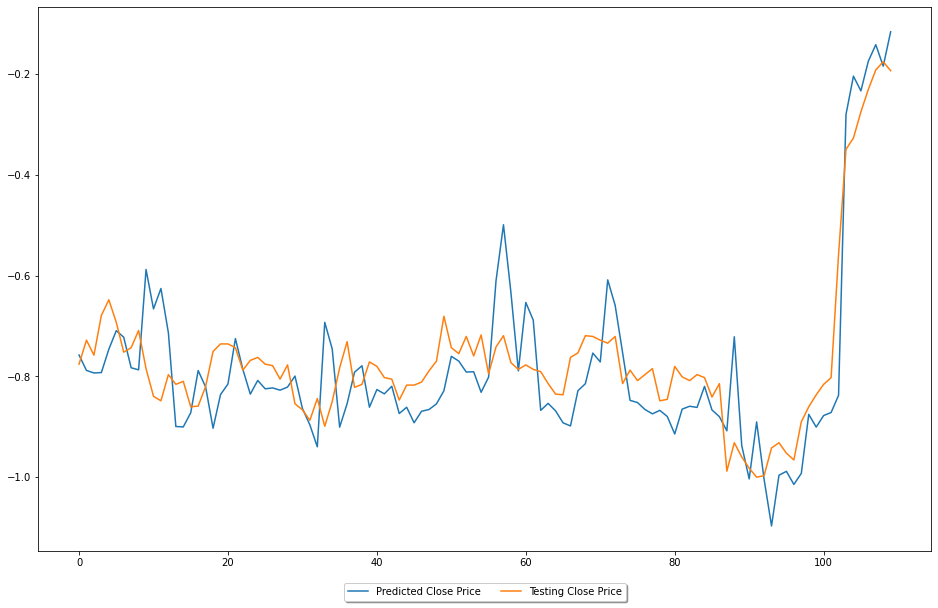

In [50]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()